In [9]:

import os
import pickle
import collections
import numpy as np
import random




class MonteCarlo():
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        # Agent parameters
        self.size = size
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        # Possible actions correspond to the set of all x,y coordinate pairs
        self.actions = []
        for i in range(size):
            for j in range(size):
                self.actions.append((i,j))
        # Initialize Q values to 0 for all state-action pairs.
        # Access value for action a, state s via Q[a][s]
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
        # Keep a list of reward received at each episode
        self.rewards = []
        self.N = collections.defaultdict(int)

    def update(self, s, s_, a, a_, r):
        self.N[s] += 1
        self.Q[a][s] += 1 / self.N[s] * (r + self.gamma * self.Q[a_][s_] - self.Q[a][s])

    def update_by_episode(self, episode):
        episode = episode[::-1]
        for i in range(len(episode) - 1):
            s, a, s_, r = episode[i]
            a_ = episode[i + 1][1]
            self.update(s, s_, a, a_, r)
        self.rewards.append(episode[0][3])
    def get_action(self, s):
        possible_actions = [a for a in self.actions if s[a[0]*self.size + a[1]] == '-']
        if random.random() < self.eps:
            action = possible_actions[random.randint(0,len(possible_actions)-1)]
        else:
            values = np.array([self.Q[a][s] for a in possible_actions])
            
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
                
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
                
                ix_select = ix_max[0]
            action = possible_actions[ix_select]
        self.eps *= (1.-self.eps_decay)

        return action

    def save(self, path):
        """ Pickle the agent object instance to save the agent's state. """
        if os.path.isfile(path):
            os.remove(path)
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()


In [10]:
import random

class Game:

    def __init__(self, agent_1, agent_2, size=3):
        self.agent_1 = agent_1
        self.agent_2 = agent_2
        self.size = size
        self.board = [['-' for _ in range(size)] for _ in range(size)]


    def agent1Move(self, action):
        self.board[action[0]][action[1]] = 'O'

    def agent2Move(self, action):
        self.board[action[0]][action[1]] = 'X'

    def checkForWin(self, key):

        diag1 = [self.board[i][i] for i in range(self.size)]
        diag2 = [self.board[i][self.size - i - 1] for i in range(self.size)]
        if diag1.count(key) == self.size or diag2.count(key) == self.size:
            return True

        for i in range(self.size):
            row = [self.board[i][j] for j in range(self.size)]
            col = [self.board[j][i] for j in range(self.size)]
            if row.count(key) == self.size or col.count(key) == self.size:
                return True

        return False

    def checkForDraw(self):
        return all(elt != '-' for row in self.board for elt in row)

    def checkForEnd(self, key):
        if self.checkForWin(key):
            return 1
        elif self.checkForDraw():
            return 0
        return -1

    def playGame(self):
        agent1_episode = []
        agent2_episode = []
        agent1_prev_state = getStateKey(self.board)
        agent1_action = self.agent_1.get_action(agent1_prev_state)
        self.agent1Move(agent1_action)
        while True:
            agent2_prev_state = getStateKey(self.board)
            agent2_action = self.agent_2.get_action(agent2_prev_state)
            self.agent2Move(agent2_action)
            if self.checkForEnd('X') != -1:
                reward = self.checkForEnd('X')
                agent1_episode.append((agent1_prev_state, agent1_action, agent2_prev_state, -reward))
                agent2_episode.append((agent2_prev_state, agent2_action, getStateKey(self.board), reward))
                break
            else:
                reward = 0
                agent1_episode.append((agent1_prev_state, agent1_action, agent2_prev_state, reward))
            agent1_prev_state = getStateKey(self.board)
            agent1_action = self.agent_1.get_action(agent1_prev_state)
            self.agent1Move(agent1_action)
            if self.checkForEnd('O') != -1:
                reward = self.checkForEnd('O')
                agent1_episode.append((agent1_prev_state, agent1_action, getStateKey(self.board), reward))
                agent2_episode.append((agent2_prev_state, agent2_action, agent1_prev_state, -reward))
                break
            else:
                reward = 0
                agent2_episode.append((agent2_prev_state, agent2_action, agent1_prev_state, reward))

        self.agent_1.update_by_episode(agent1_episode)
        self.agent_2.update_by_episode(agent2_episode)
        print(agent1_episode)
        print(agent2_episode)
        print("-"*100)


    def start(self, episodes=1000):
        for _ in range(episodes):
            print(f"{_}:")
            self.playGame()
            self.board = [['-' for _ in range(self.size)] for _ in range(self.size)]
        self.agent_1.save('agent_1.pkl')
        self.agent_2.save('agent_2.pkl')



def printBoard(board, size):
    """
    Prints the game board as text output to the terminal.

    Parameters
    ----------
    board : list of lists
        the current game board
    size : int
        the size of the board (3, 4, or 5)
    """
    header = '    ' + '   '.join(str(i) for i in range(size))
    print(header + '\n')
    for i, row in enumerate(board):
        print('%i   ' % i, end='')
        for elt in row:
            print('%s   ' % elt, end='')
        print('\n')


def getStateKey(board):
    """
    Converts 2D list representing the board state into a string key
    for that state. Keys are used for Q-value hashing.

    Parameters
    ----------
    board : list of lists
        the current game board
    """
    return ''.join(''.join(row) for row in board)

In [11]:
monte_1 = MonteCarlo(alpha=0.5, gamma=0.9, eps=0.1, size=4)
monte_2 = MonteCarlo(alpha=0.5, gamma=0.9, eps=0.1, size=4)
game = Game(agent_1=monte_1, agent_2=monte_2, size=4)

print(game.start(10000))

0:
[('----------------', (3, 1), '-------------O--', 0), ('---X---------O--', (0, 1), '-O-X---------O--', 0), ('-O-X------X--O--', (3, 0), '-O-X------X-OO--', 0), ('-OXX------X-OO--', (1, 2), '-OXX--O---X-OO--', 0), ('-OXX--O---XXOO--', (0, 0), 'OOXX--O---XXOO--', 0), ('OOXX--O-X-XXOO--', (2, 1), 'OOXX--O-XOXXOO--', 0), ('OOXXX-O-XOXXOO--', (3, 3), 'OOXXX-O-XOXXOO-O', 0), ('OOXXXXO-XOXXOO-O', (3, 2), 'OOXXXXO-XOXXOOOO', 1)]
[('-------------O--', (0, 3), '---X---------O--', 0), ('-O-X---------O--', (2, 2), '-O-X------X--O--', 0), ('-O-X------X-OO--', (0, 2), '-OXX------X-OO--', 0), ('-OXX--O---X-OO--', (2, 3), '-OXX--O---XXOO--', 0), ('OOXX--O---XXOO--', (2, 0), 'OOXX--O-X-XXOO--', 0), ('OOXX--O-XOXXOO--', (1, 0), 'OOXXX-O-XOXXOO--', 0), ('OOXXX-O-XOXXOO-O', (1, 1), 'OOXXXXO-XOXXOO-O', -1)]
----------------------------------------------------------------------------------------------------
1:
[('----------------', (2, 2), '----------O-----', 0), ('--X-------O-----', (3, 1), '--X-------O

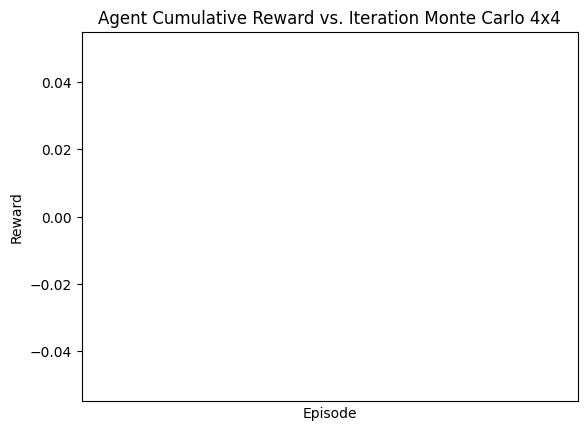

In [12]:
import os
import pickle
import sys
import numpy as np
import matplotlib.pylab as plt

with open("agent_1.pkl", 'rb') as f:
    agent = pickle.load(f)

def plot_agent_reward(rewards):
    """ Function to plot agent's accumulated reward vs. iteration """

    # Plot cumulative rewards
    plt.plot(np.cumsum(rewards))

    # Set the title and labels
    plt.title('Agent Cumulative Reward vs. Iteration Monte Carlo 4x4')
    plt.ylabel('Reward')
    plt.xlabel('Episode')

    # Improve x-axis by adding more ticks
    num_episodes = len(rewards)
    plt.xticks(np.arange(0, num_episodes, step=max(1, num_episodes // 10)))  # Adjust the step to control tick frequency

    # Optionally, rotate x-tick labels if they overlap
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()
plot_agent_reward(agent.rewards)
